In [ ]:
#This notebook is designed to be converted to a HTML slide show
#To do this in the command prompt type (in the folder containing the notebook): 
#       jupyter nbconvert *.ipynb --to slides

# **Simulating Chemical Reaction Networks with Bioscrape**
## BE 240 April 6th 2020
### _William Poole_

**Overview:** In this tutorial, we will review deterministic and stochastic mass action chemical reaction networks (CRNs) and how to simulate them using [BioSCRAPE](https://github.com/ananswam/bioscrape).

## What is a CRN?
A CRN is a widely established model of chemistry and biochemistry.
* A set of species $S$
* A set of reactions $R$ interconvert species $I_r$ to $O_r$

\begin{align}
\\
I \xrightarrow[]{\rho(s)} O
\\
\end{align}

 * $I$ and $O$ are multisets of species $S$. 
 * $\rho(s): S \to \mathbb{R}$ is a function that determines how fast the reaction occurs.



### Example
\begin{equation}
\emptyset  \underset{1}{\overset{100}\rightleftharpoons}  2 A
\end{equation}

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: The following species are uninitialized and their value has been defaulted to 0: A, 
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes ins

Text(0, 0.5, 'Concentration \n (Stochastic Counts)')

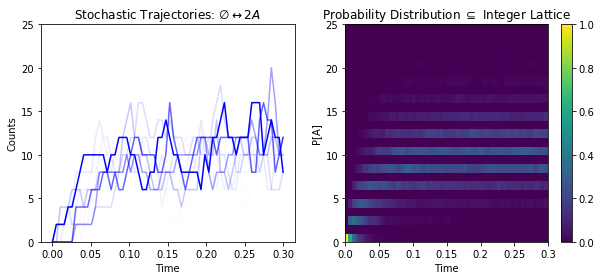

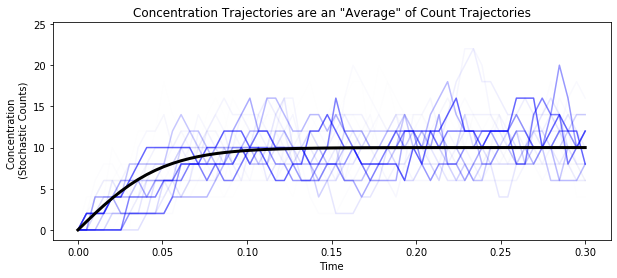

In [1]:
#Plot the example - code not shown in lecture

#Using Bioscrape: Basic Imports
from bioscrape.types import Model
from bioscrape.simulator import py_simulate_model
#For arrays and plotting
import numpy as np
import pylab as plt

#Create a CRN
CRN = Model(species = ["A"], reactions = [([], ["A", "A"], "massaction", {"k":100}), (["A", "A"], [], "massaction", {"k":1})])


T = 60 #Number of time-points
N = 500 #Number of Simulations
tmax = .3 #Max time
timepoints = np.linspace(0, tmax, T)
HM = np.zeros((T, 25)) #Heatmap for storing the probability distirbution P[t, A]

#Run N simulations
for i in range(N):
    #Simulate model stochastically
    R = py_simulate_model(timepoints = timepoints, Model = CRN, stochastic = True)
    
    #Add to HM dist
    for t in range(T):
        if R["A"][t] < 25: #Truncate if the value is out of the heatmap (very rare)
            HM[t, int(R["A"][t])]+=1/N #Renomralize per simulation
    

    plt.figure("fig stoch", figsize = (10, 4))
    plt.subplot(121)
    plt.plot(timepoints, R["A"], color = (0, i/N, 1-i/N), alpha = np.exp(-i/2))

    plt.figure("fig det", figsize = (10, 4))
    plt.plot(timepoints, R["A"], color = (0, i/N, 1-i/N), alpha = .6*np.exp(-i/5))

plt.figure("fig stoch")
plt.title("Stochastic Trajectories: $\emptyset \leftrightarrow 2A$")
plt.xlabel("Time")
plt.ylabel("Counts")
plt.ylim(0, 25)
plt.subplot(122)
plt.title("Probability Distribution $\subseteq$ Integer Lattice")
cb = plt.pcolor(HM.T)
plt.colorbar(cb)
plt.xlabel("Time")
plt.ylabel("P[A]")
plt.xticks([10*i for i in range(int(T/10)+1)], [str(round(i/T*tmax*10, 3)) for i in range(int(T/10)+1)])

plt.figure("fig det")
R = py_simulate_model(timepoints = timepoints, Model = CRN, stochastic = False) #Deterministic Simulation
plt.plot(timepoints, R["A"], color = 'black', lw = 3)
plt.title('Concentration Trajectories are an "Average" of Count Trajectories')
plt.xlabel("Time")
plt.ylabel("Concentration \n (Stochastic Counts)")

# CRNs can be interpreted stochastically

**Stochastic Semantics** considers the probability of counts of molecules:


\begin{align}
\frac{d \mathbb{P}[s]}{dt} = \sum_r \mathbb{P}[s + \Delta_r] \rho_r(s + \Delta_r) - \mathbb{P}[s]\rho_r(s)
\end{align}

* This equation is the **chemical master equation** and can be simulated via the [Gillespie Algorithm](http://cctbio.ece.umn.edu/wiki/images/7/78/Gillespie-Daniel-T_Stochastic_Simulation_of_Chemical_Kinetics.pdf) as a Markov jump process
* $s_i = \textrm{count} (S_i)$
* $\rho_r(s)$ is called the "propensity" of reaction $r$
* $\Delta_r = O_r - I_r$ is the stochiometric matrix

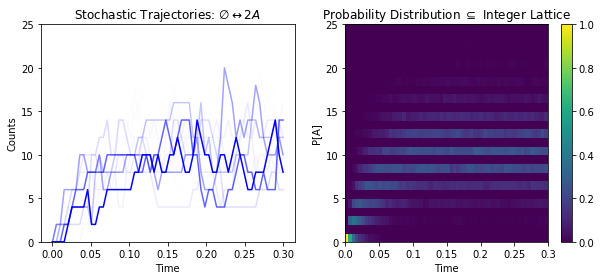

> Steady state distribution at the higher counts because no color change

## CRNs can be interpreted deterministically

**Deterministic Semantics** considers the concentrations of molecules:
> Concentration is not expected value but funky limit. Dynamics of deterministic CRN are average of stochastic CRN

\begin{equation}
\lim_{s_i, V \to \infty} \textrm{ s.t. } \frac{s_i}{V} = [S_i] \quad \quad \quad \frac{d[S]}{dt} = \sum_r \Delta_r \rho_r([S])
\end{equation}

* This limit is subtle and is not the same as the expected value.
* The dynamics are an ordinary differential equation (ODE):
* $\rho_r([S])$ is called the "rate function" of reaction $r$
> rate function = propensity. deterministic - assume concentration, stochastic - assume counts

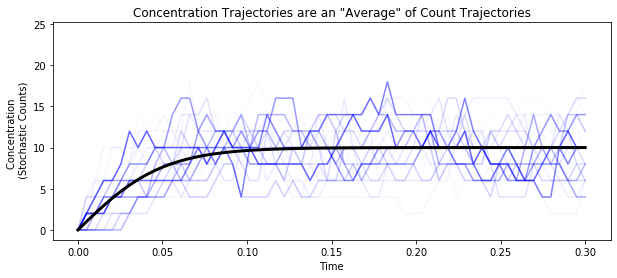


## Deterministic Law of Mass Action

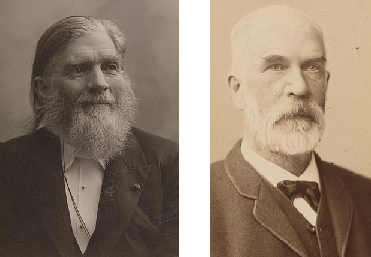

_Peter Waage (left) and  Cato Maximilian Guldberg (right) developed the "Laws of Mass Action" in the late 1800's. You probably learned these laws in your introductory undergraduate chemistry course._
  
    
For a reaction $A + B \underset{k^-}{\overset{k^+}\rightleftharpoons} C + D$, at equilibrium:
  

    
\begin{align}
k^+ [A][B] = k^-[C][D]
\end{align}

## The Deterministic Mass Action Rate Equation:

\begin{align}
\\
\rho_r([S]) =k_r \prod_i [S_i]^{I_i}
\end{align}


Some Examples:
\begin{align}
\\
\emptyset &\xrightarrow{k} A \quad \quad &&\rho([S]) = k
\\ \\
A &\xrightarrow{k} B \quad \quad &&\rho([S]) = k [A]
\\ \\
3A + B &\xrightarrow{k} C + D \quad \quad &&\rho([S]) = k [A]^3 [B]
\end{align}
> Product doesn't matter, only inputs

## Stochastic Massaction Propensities Arrise from Statistical Physics

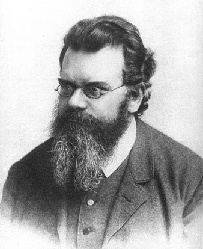
_Ludwig Eduard Boltzmann invented kinetic theory, which is a foundation of stochastic chemical reaction network theory._

Consider the reaction:
\begin{equation}
A + B \xrightarrow[]{k}C + D \quad \quad \quad \quad \rho(A, B) = \frac{1}{V} k A B
\end{equation}

For this reaction to occur, $A$ and $B$ must collide in solution. The rate constant $k$ is defined as the rate each molecule of $A$ has of colliding with each molecule of $B$ and reacting to form $C + D$ per unit concentration. Recalling that concentration is $[\cdot] = \frac{\textrm{count }(\cdot)}{V}$, we have the divide by $V$ multiply by the counts of each species.


## The General Stochastic Massaction Propensities Function:



\begin{align}
\\
I &\xrightarrow[]{k_r} O \quad \quad &&\rho(s) = \frac{k_r}{V^{|I|-1}} \prod_i \frac{s_i!}{(s_i - I_i)!}
\end{align}


Some Examples:


\begin{align}
\\
\emptyset &\xrightarrow{k} A \quad \quad &&\rho(s) = k V \\ \\
A &\xrightarrow{k} B \quad \quad &&\rho(s) = k A \\ \\
3A + B &\xrightarrow{k} C + D \quad \quad &&\rho(s) = \frac{k}{V^3} A(A-1)(A-2) B
\end{align}


## The Well Mixed Assumption

Both the deterministic and stochastic mass-action functions assume that the solution is "well mixed" meaning if molecules $A$ and $B$ just reacted, they are not more likely to react again compared to other reactions with molecules $C$, $D$, etc. In other words, diffusion is fast compared to to the rates of chemical reactions.

### Examples of well mixed reactions:
* Test-tube chemical reactions like PCR
* Chemical reactions in the cytoplasm in a cell

### Examples of reactions which are not necessarily well mixed:
* Interactions between proteins bound to the same piece of DNA
* Interactions occuring occuring in multiple cellular organelles


# When to use stochastic simulation versus deterministic?

### Stochastic:
* Small Copy number of molecules ($n<20$)
* Investigating noise and variance
* Single cell data (microscopy, flow cytometry)

### Deterministic:
* Large copy number ($n>100$)
* Investigating bulk or average behavior (plate reader data, populations of cells)
* When analytic and/or numerical tractability are important



## What Is Bioscrape?

### Biological Circuit Stochastic Simulation of Single Cell Reactions and Parameter Estimation

Bioscrape is python software to simulate CRNs deterministically or stochastically
* Also does parameter inference and simulates single cells....to be discussed in future lectures


_Biocrape is designed to be fast and modable with a python API so it can be connected into data/modelling pipelines_

## Bioscrape is FAST! 
* You can do tons of simulations very quickly to explore parameter space or large numbers of potential circuits
* Uses Cython (special python code that compiles into C)
* Multiple highly optimized simulators

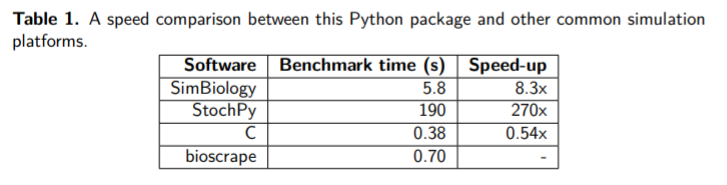

_The benchmark test used for comparing the speed of these different simulators is a simple gene expression model consisting of just four stochastic reactions: transcription, translation, and degradation of mRNA and protein._

## Bioscrape is Object Oriented and Customizable
* Models, Simulators, Propensities, Delays, etc. are all objects so the code can be extended using python and cython

* **Available Simulators:** Deterministic ODE, Stochastic, Stochastic with Delay see basic_examples_START_HERE notebook or Bioscrape Wiki), Stochastic Single Cell Lineage (covered later in the course)

* **Available Propensities:** Massaction, Hill Functions (covered next week), General Algebraic Expressions (see Bioscrape Wiki)

* **Other Core Objects:** Delays (se basic_examples_START_HERE notebook or Bioscrape Wiki), Rules (covered next week), Model Interfaces

_If you are interested in learning more or extending the software, let me know and I will organize a developer tutorial._

# Other Similar Software

For Simulating SBML (CRN) Models:
* [iBioSim](https://github.com/MyersResearchGroup/iBioSim): Extensive suite for simulating metabolic and signalling networks. Included analysis tools. Also supports SBOL.
* [COPASI](http://copasi.org/): "Environment" for creating and simulating SBML models. Written in C without a python API.
* [SimBiology](https://www.mathworks.com/products/simbiology.html): MATLAB biological simulation toolbox. Lots of analysis functionality. Slower than bioscrape.
* [libRoadRunner](https://academic.oup.com/bioinformatics/article/31/20/3315/195758): Very fast CRN simulation (C++) via SBML. Difficult to extend. Python API available.

[Complete List Available Here](https://github.com/BuildACell/txtlsim-python/wiki/Modeling-and-Analysis-Tools-for-Synthetic-Biology). Thanks to Ayush Pandey for putting this together!
> bioscrape allows single cell simulation, which the others don't

# A Biochemical Signalling Model

A signal cooperatively $S$ binds to a transcription factor $F^0$ changing its conformation to $F^1$. $F^1$ binds to a gene $G^0$ activating it to $G^1$. A polymerase $P$ can bind to $G^1$ and then transcribes a transcript $T$. The transcript can bind to a ribosome $R$ and be translated to a protein $X$. The signalling molecule, transcripts, proteins are assumed to degrade via dilution. Cellularly machinery ($F$, $P$, and $R$) DNA ($G$) are assumed to be a constant concentration.

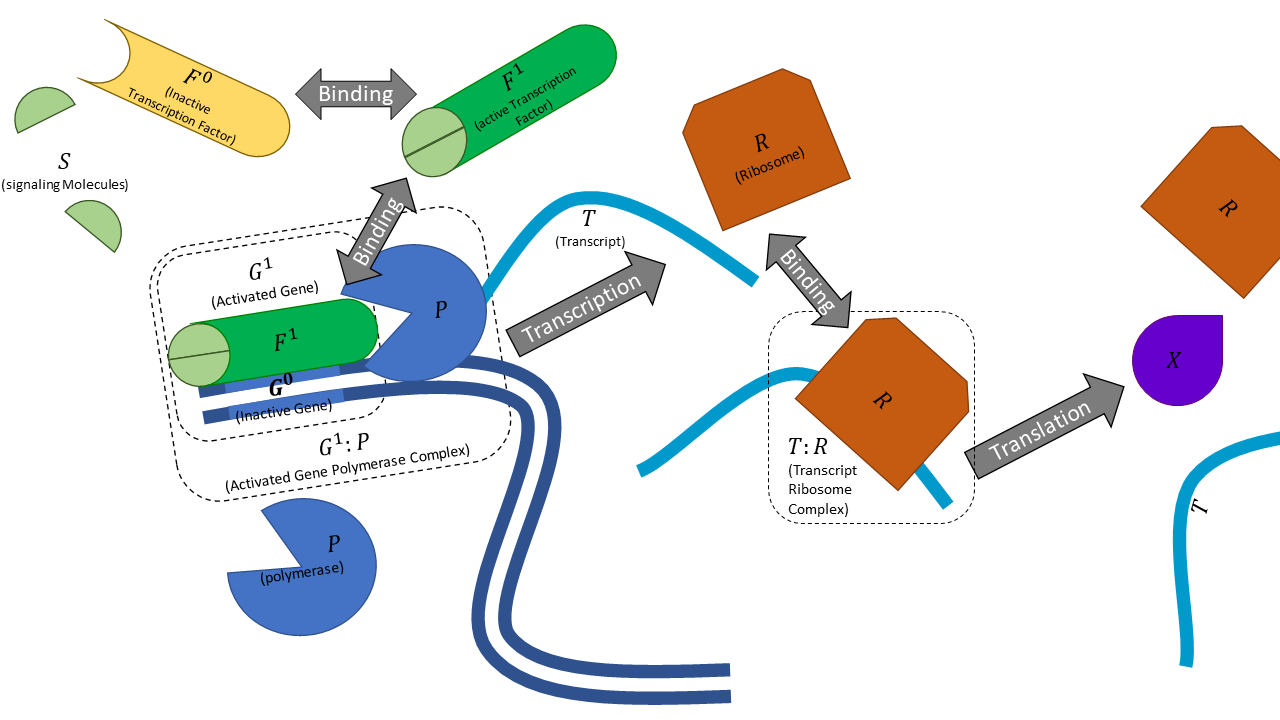

\begin{align}
2 S + F^0 &\underset{k^u_1}{\overset{k^b_1}\rightleftharpoons} F^1\\
F^1 + G^0 &\underset{k^u_2}{\overset{k^b_2}\rightleftharpoons} G^1 \\
G^1 + P &\underset{k^u_3}{\overset{k^b_3}\rightleftharpoons} G^1 :P \xrightarrow{k_{tx}} G^1 + P + T \\
T + R &\underset{k^u_4}{\overset{k^b_4}\rightleftharpoons} T :R \xrightarrow{k_{tl}} T + R + X \\
S &\xrightarrow{\delta} \emptyset \\
T &\xrightarrow{\delta} \emptyset \\
X &\xrightarrow{\delta} \emptyset
\end{align}

## Basic Bioscrape Imports

In [3]:
#Using Bioscrape: Basic Imports

#A Model is a CRN with some bells and whistles
from bioscrape.types import Model

#py_simulate_model is a helper function that takes care of may details for you
from bioscrape.simulator import py_simulate_model

#For arrays and plotting
import numpy as np
import pylab as plt

## Bioscrape Models Require:
* Species \[A list of strings\]
* Parameters \[list of tuples (string, value)\]
* Reactions \[list of tuples ( \[ input species \], \[output species\], (str) propensity type, {propensity parameter dictionary} ) \]
* Initial condition {dictionary species (str): value}

In [4]:
#A Model Requires:

#Species: A list of all the species
species = ["S", "F0", "F1", "G0", "G1", "P", "G1:P", "T", "R", "T:R", "X"]

In [6]:
#A Model Requires:

#Parameters: List of tuples [("paramter name" (string), value (float))]
parameters = [("k1b", 100), ("k1u",20), 
          ("k2b", 50), ("k2u", 10), 
          ("k3b", 30), ("k3u", 10), 
          ("k4b", 80), ("k4u", 2),
          ("ktx", .5), ("ktl", 5), ("delta", .5)]

In [7]:
#A Model Requires:

#Reactions: A list of reactions [rxn1, rxn2...]. Each reaction is a tuple ([Input Species], [Output Species], "propensity_type", {propensity_parameters})

#2S + F0 --> F1 @ k = k1b
rxn1b = (["S", "S", "F0"], ["F1"], "massaction", {"k":"k1b"})

#F1 --> S + F0 @ k = k1u
rxn1u = (["F1"], ["S", "S", "F0"], "massaction", {"k":"k1u"})

#All other binding/unbinding reactions
rxn2b, rxn2u = (["F1", "G0"], ["G1"], "massaction", {"k":"k2b"}), (["G1"], ["G0", "F1"], "massaction", {"k":"k2u"})
rxn3b, rxn3u = (["G1", "P"], ["G1:P"], "massaction", {"k":"k3b"}), (["G1:P"], ["G1", "P"], "massaction", {"k":"k3u"})
rxn4b, rxn4u = (["T", "R"], ["T:R"], "massaction", {"k":"k4b"}), (["T:R"], ["T", "R"], "massaction", {"k":"k4u"})

#Transcription, *Activated complex is the first entrance*
rxntx = (["G1:P"], ["G1", "P", "T"], "massaction", {"k":"ktx"})

#Translation
rxntl = (["T:R"], ["T", "R", "X"], "massaction", {"k":"ktl"})

#Degredation -- Notice reactions can share parameters! *This way, just have to change param value*
rxndt = (["T"], [], "massaction", {"k":"delta"})
rxndx = (["X"], [], "massaction", {"k":"delta"})
rxnds = (["S"], [], "massaction", {"k":"delta"})

# *Put all parameters in a list*
reactions = [rxn1b, rxn1u, rxn2b, rxn2u, rxn3b, rxn3u, rxn4b, rxn4u, rxntx, rxntl, rxndt, rxndx, rxnds]

In [8]:
#A Model Requires:

#An initial condition for each species (uninitialized species default to 0) *formatted as a dictionary*
x0 = {
    "S":200,
    "F0":10,
    "G0":1,
    "P":25,
    "R":100,
}

## Simulating with Biocrape
* Instantiate a model: M = Model(species = species, parameters = parameters, reactions = reactions, initial_condition_dict = x0)
* Then use py_simulate_model(timepoints, model = M, stochastic = True / False)
* Plot the results (which are conveniently **returned as Pandas Dataframes**)

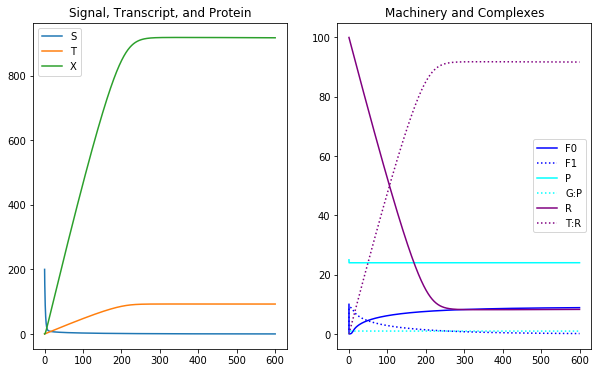

In [9]:
#Bioscrape is Object Oritened: Models, Propensities, Simulators, etc. are all Objects

#Instantiate the Model [The only object must of us will care about]
M = Model(species = species, reactions = reactions, parameters = parameters, initial_condition_dict = x0)


#Simulate the Model
timepoints = np.linspace(0, 600, 10000)

Results = py_simulate_model(timepoints, Model = M, stochastic = False) #py_simulate_model takes care of all other objects for you

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: The following species are uninitialized and their value has been defaulted to 0: F1, G1, G1:P, T, T:R, X, 
  after removing the cwd from sys.path.


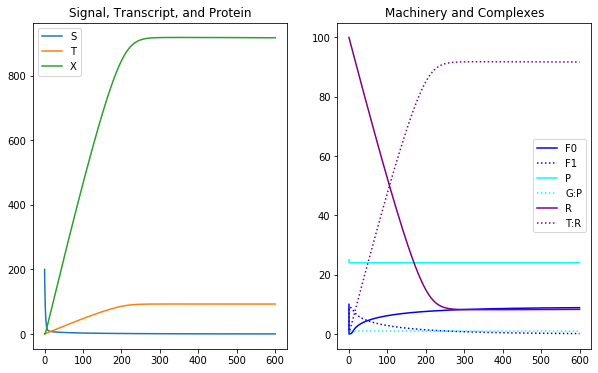

In [10]:
#Bioscrape returns a Pandas Dataframe by default, so plotting is easy!

plt.figure(figsize = (10, 6))
plt.subplot(121)
plt.title("Signal, Transcript, and Protein")
plt.plot(timepoints, Results["S"]+Results["F1"], label = "S")
plt.plot(timepoints, Results["T"]+Results["T:R"], label = "T")
plt.plot(timepoints, Results["X"], label = "X")
plt.legend()

plt.subplot(122)
plt.title("Machinery and Complexes")
plt.plot(timepoints, Results["F0"], color = 'blue', label = "F0")
plt.plot(timepoints, Results["F1"], ":", color = 'blue', label = "F1")
plt.plot(timepoints, Results["P"], color = "cyan", label = "P")
plt.plot(timepoints, Results["G1:P"], ":", color = "cyan", label = "G:P")
plt.plot(timepoints, Results["R"], color = "purple", label = "R")
plt.plot(timepoints, Results["T:R"], ":", color = "purple", label = "T:R")
plt.legend()


> BioSCRAPE is better for simple models, Next week - model reductions <br>
> Updated Jupyter Notebook also has References for other stuff

## Varying Parameters is Easy!
* Just use .set_parameter("parameter name", value) on your Model object

/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
odeint failed with mxstep=500...odeint failed with mxstep=500...odeint failed with mxstep=500...odeint failed with mxstep=500...odeint failed with mxstep=500...odeint failed with mxstep=500...odeint failed with mxstep=500...odeint failed with mxstep=500...odeint failed with mxstep=500...

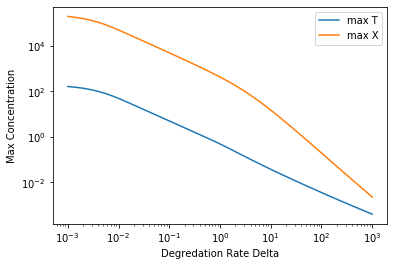

In [11]:
#Because parameters are named, it is very easy and fast to change parameter values to understand how the effect a system.

Tmax = []
Xmax = []

#Change the degredation rate of X, T, and S all at once. going from 10^-3 to 10^3 with 100 spaced in logspace
deltas = np.logspace(-3, 3, 100)

for delta in deltas:
    M.set_parameter("delta", delta) #It much more efficient to change model parameters than re-instantiate new models
    Results = py_simulate_model(timepoints, Model = M)
    Tmax.append(np.max(Results["T"])) # only looking at maximum T and max X
    Xmax.append(np.max(Results["X"]))
    
plt.figure()
plt.loglog(deltas, Tmax, label = "max T")
plt.loglog(deltas, Xmax, label = "max X")
plt.xlabel("Degredation Rate Delta")
plt.ylabel("Max Concentration")
plt.legend()
# errors due to the fact that log space gives strange floats which gave problems for some reason

## Varying Species Values is Easy Too!
* Just use .set_species({"species name":value}) on your Model object

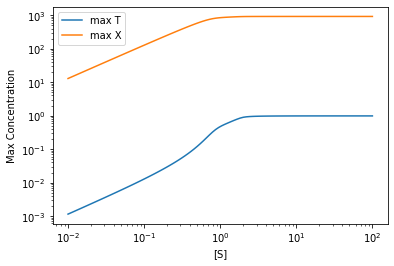

In [12]:
#Or we could get a dose response curve by changing the initial condition of S

#COMMON ERROR ALERT!
#Reset the parameter delta - parameter changes are permanent until you reset them
M.set_parameter("delta", .5)

Tmax = []
Xmax = []

#Different initial values of S **looking at an induction curve here**
S0s = np.logspace(-2, 2, 100)

for s0 in S0s:
    x0["S"] = s0 #Change my initial condition dictionary
    M.set_species(x0)
    Results = py_simulate_model(timepoints, Model = M, stochastic = False)
    Tmax.append(np.max(Results["T"]))
    Xmax.append(np.max(Results["X"]))

plt.figure()
plt.loglog(S0s, Tmax, label = "max T")
plt.loglog(S0s, Xmax, label = "max X")
plt.xlabel("[S]")
plt.ylabel("Max Concentration")
plt.legend()

## Analyzing Stochastic Simulations
* Use py_simulate_model(timepoints, model = Model, stochastic = True)
* But now the data is more complex to understand
* Best to think of stochastic trajectories as experiments - you may need multiple samples!

> Things get a bit complicated in stochastic. Data is random and harder to understand

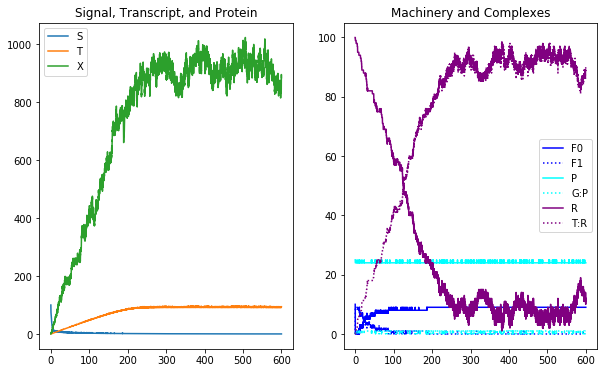

In [20]:
#Remember to reset modified variables!
x0["S"] = 200

#Switching to Stochastic Simulation is easy!
Results_stoch = py_simulate_model(timepoints, Model = M, stochastic = True) #py_simulate_model takes care of all other objects for you

#Same plotting as before...
plt.figure(figsize = (10, 6))
plt.subplot(121)
plt.title("Signal, Transcript, and Protein")
plt.plot(timepoints, Results_stoch["S"]+Results["F1"], label = "S")
plt.plot(timepoints, Results_stoch["T"]+Results["T:R"], label = "T")
plt.plot(timepoints, Results_stoch["X"], label = "X")
plt.legend()

plt.subplot(122)
plt.title("Machinery and Complexes")
plt.plot(timepoints, Results_stoch["F0"], color = 'blue', label = "F0")
plt.plot(timepoints, Results_stoch["F1"], ":", color = 'blue', label = "F1")
plt.plot(timepoints, Results_stoch["P"], color = "cyan", label = "P")
plt.plot(timepoints, Results_stoch["G1:P"], ":", color = "cyan", label = "G:P")
plt.plot(timepoints, Results_stoch["R"], color = "purple", label = "R")
plt.plot(timepoints, Results_stoch["T:R"], ":", color = "purple", label = "T:R")
plt.legend()

## Collecting Statistics from a single stochastic trajectory

The below example illustrates how important it is to be careful when averaging over a stochastic trajectory. Including the early part of a stochastic simulation in a steady-state average can result in bias due to transient behavior. Not sampling the steady-state "typical set" sufficiently can result in noisy statistics.

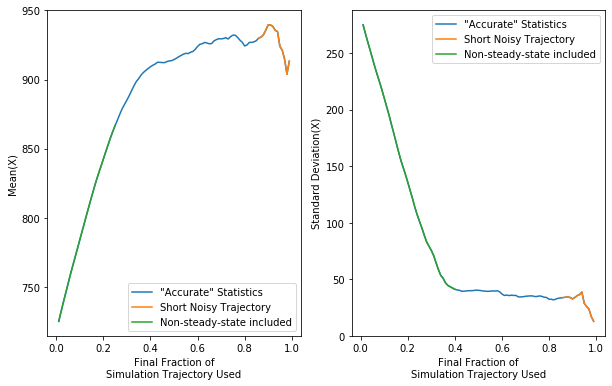

In [21]:
# Burn in and sampling noise in one simulation
#This matters for steady-state statistics
#time dependent statistics require many simulations (see below)

Results_stoch = py_simulate_model(timepoints, Model = M, stochastic = True) #py_simulate_model takes care of all other objects for you

plt.figure(figsize = (10, 6))
plt.subplot(121)
percentages = np.arange(1, 0, -.01) 
plt.plot(percentages,[np.mean(Results_stoch["X"][int(t*len(timepoints)):]) for t in percentages], label = '"Accurate" Statistics')
plt.plot(percentages[:15],[np.mean(Results_stoch["X"][int(t*len(timepoints)):]) for t in percentages[:15]], label = "Short Noisy Trajectory")
plt.plot(percentages[75:],[np.mean(Results_stoch["X"][int(t*len(timepoints)):]) for t in percentages[75:]], label = "Non-steady-state included")
plt.ylabel("Mean(X)")
plt.xlabel("Final Fraction of\nSimulation Trajectory Used")
plt.legend()


plt.subplot(122)

plt.plot(percentages,[np.std(Results_stoch["X"][int(t*len(timepoints)):]) for t in percentages], label = '"Accurate" Statistics')
plt.plot(percentages[:15],[np.std(Results_stoch["X"][int(t*len(timepoints)):]) for t in percentages[:15]], label = "Short Noisy Trajectory")
plt.plot(percentages[60:],[np.std(Results_stoch["X"][int(t*len(timepoints)):]) for t in percentages[60:]], label = "Non-steady-state included")
plt.ylabel("Standard Deviation(X)")
plt.xlabel("Final Fraction of\nSimulation Trajectory Used")
plt.legend()

> Why does standard deviation go down at the end: there are local, temporal correlations. Assume fluctuations - they are short term/local, so the standard deviation goes down because we are only looking at short times windows. Mean can go up or down - that can vary depending upon the direction of the fluctuation. If mean goes down, standard deviation still goes down.

## Collecting Samples from Multiple Stochastic Trajectories
The below example illustrates how multiple stochastic trajectories allow for time-dependent statistics, including transient and steady-state dynamics. There is a computational trade-off between the time spent on individual trajectories and the number of trajectories simulated. For time-dependent statistics, more trajectories may be more important than simulating them longer. For steady-state statistics, fewer longer simulations may be better. That said, these rules of thumb depend on the system of interest and may become very complex in large multi-modal systems.

Text(0, 0.5, 'mean X')

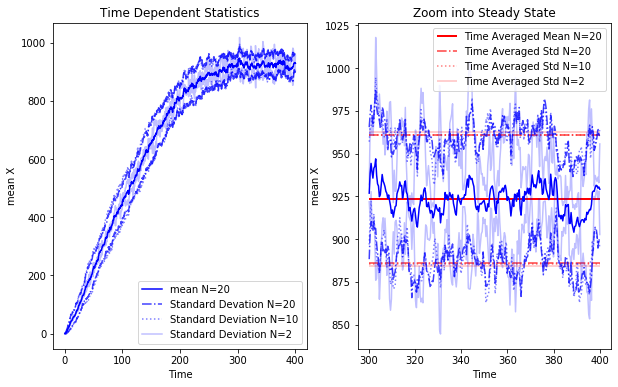

In [23]:
#If we do lots of simulations, we can calculate both better steady state results AND time-dependent statistics

N = 20 #Number of simulations

timepoints = np.linspace(0, 400, 1000) #New Timepoints for faster simulations

samples = np.zeros((N, len(timepoints)))
for i in range(N):
    Results_stoch = py_simulate_model(timepoints, Model = M, stochastic = True)
    samples[i, :]= Results_stoch["X"]

    
#Calculate Time Dependent Statistics
meanX = np.mean(samples, 0)
std100 = np.std(samples, 0) #100% of samples used to calculate standard deviation
std50 = np.std(samples[:int(N/2), :], 0) #50% of samples
std10 = np.std(samples[:int(N/10), :], 0) #10% of samples

#Calculate Steady State Statistics
ss_start = 750 #Time index to start steady state calculation
meanXss = np.mean(meanX[ss_start:]) #Steady State Mean
std100ss = np.std(samples[:, ss_start:]) #100% of samples used to calculate steady state standard deviation
std50ss = np.std(samples[:int(N/2), ss_start:]) #50% of samples
std10ss = np.std(samples[:int(N/10), ss_start:]) #10% of samples


#Plotting below
plt.figure(figsize = (10, 6))
plt.subplot(121)
plt.title("Time Dependent Statistics")

plt.plot(timepoints, meanX, color = 'blue', label = "mean N="+str(N))
plt.plot(timepoints, meanX+std100,"-.", color = 'blue', alpha = .75, label = "Standard Devation N="+str(N))
plt.plot(timepoints, meanX-std100,"-.", color = 'blue', alpha = .75)
plt.plot(timepoints, meanX+std50,":", color = 'blue', alpha = .5, label = "Standard Deviation N="+str(int(N/2)))
plt.plot(timepoints, meanX-std50,":", color = 'blue', alpha = .5)
plt.plot(timepoints, meanX+std10, color = 'blue', alpha = .25, label = "Standard Deviation N="+str(int(N/10)))
plt.plot(timepoints, meanX-std10, color = 'blue', alpha = .25)

plt.legend()
plt.xlabel("Time")
plt.ylabel("mean X")

plt.subplot(122)
plt.title("Zoom into Steady State")

plt.plot(timepoints[ss_start:], meanX[ss_start:], color = 'blue')
plt.plot(timepoints[ss_start:], meanX[ss_start:]+std100[ss_start:],"-.", color = 'blue', alpha = .75)
plt.plot(timepoints[ss_start:], meanX[ss_start:]-std100[ss_start:],"-.", color = 'blue', alpha = .75)
plt.plot(timepoints[ss_start:], meanX[ss_start:]+std50[ss_start:],":", color = 'blue', alpha = .5)
plt.plot(timepoints[ss_start:], meanX[ss_start:]-std50[ss_start:],":", color = 'blue', alpha = .5)
plt.plot(timepoints[ss_start:], meanX[ss_start:]+std10[ss_start:], color = 'blue', alpha = .25)
plt.plot(timepoints[ss_start:], meanX[ss_start:]-std10[ss_start:], color = 'blue', alpha = .25)

plt.hlines(meanXss, timepoints[ss_start], timepoints[-1], lw = 2, color = 'red', label = "Time Averaged Mean N="+str(N))
plt.hlines(meanXss+std100ss, timepoints[ss_start], timepoints[-1], ls = "-.", alpha = .75, color = 'red', label = "Time Averaged Std N="+str(N))
plt.hlines(meanXss-std100ss, timepoints[ss_start], timepoints[-1], ls = "-.", alpha = .75, color = 'red')
plt.hlines(meanXss+std50ss, timepoints[ss_start], timepoints[-1], ls = ":", alpha = .5, color = 'red', label = "Time Averaged Std N="+str(int(N/2)))
plt.hlines(meanXss-std50ss, timepoints[ss_start], timepoints[-1], ls = ":", alpha = .5, color = 'red')
plt.hlines(meanXss+std10ss, timepoints[ss_start], timepoints[-1], alpha = .25, color = 'red', label = "Time Averaged Std N="+str(int(N/10)))
plt.hlines(meanXss-std10ss, timepoints[ss_start], timepoints[-1], alpha = .25, color = 'red')

plt.legend()
plt.xlabel("Time")
plt.ylabel("mean X")

<font color='purple'>
> 2 simulations, lot of standard deviation. Suggesting that, for this particular system, 10 is enough to calculate for this system (2 too little, 20 too much)
<br>
> If i care about dynamics, might want to do 10. Need to analyze stochastic carefully. Numerical analyses, useful, fast and easy in bioscrape
<br>
</font>

## In this example, we compare stochastic and deterministic dynamics. For what parameter values are the two qualitatively similar and different?
* Also try running very long simulations - for some species values, the dynamics can look very different in this situation. What is happening?

> overlay stochastic on top of deterministic <br>
> Let's make the number of ribosomes smaller ('R' 10 instead of 100) (also if we changed P)
> - noisier but similar

/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
odeint failed with mxstep=500...

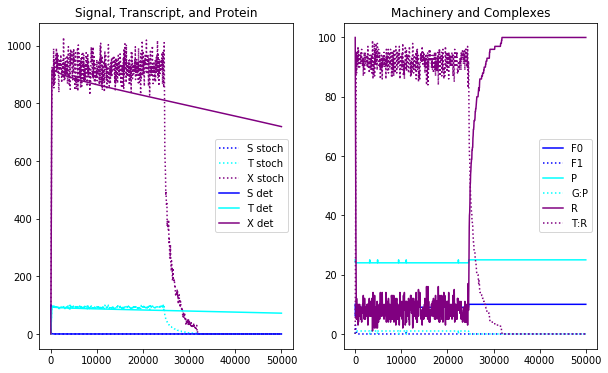

In [35]:
#What species values will make these model qualitatively different?

#Simulate deterministic versus stochastic
#Original Values: x0 = {"S":200, "F0":10,"G0":1,"P":25,"R":100}
x0 = {
    "S":100,
    "F0":10,
    "G0":1,
    "P":25,
    "R":100,
}
M.set_species(x0)
timepoints = np.linspace(0, 50000, 1000) #try a very long simulation ~50000
Results_det = py_simulate_model(timepoints, Model = M, stochastic = False) 
Results_stoch = py_simulate_model(timepoints, Model = M, stochastic = True)


#Same plotting as before...
plt.figure(figsize = (10, 6))
plt.subplot(121)
plt.title("Signal, Transcript, and Protein")
plt.plot(timepoints, Results_stoch["S"]+Results_stoch["F1"], ":", label = "S stoch", color = 'blue')
plt.plot(timepoints, Results_stoch["T"]+Results_stoch["T:R"], ":", label = "T stoch", color = 'cyan')
plt.plot(timepoints, Results_stoch["X"], ":", label = "X stoch", color = 'purple')

plt.plot(timepoints, Results_det["S"]+Results_det["F1"], label = "S det", color = 'blue')
plt.plot(timepoints, Results_det["T"]+Results_det["T:R"], label = "T det", color = 'cyan')
plt.plot(timepoints, Results_det["X"], label = "X det", color = 'purple')
plt.legend()

plt.subplot(122)
plt.title("Machinery and Complexes")
plt.plot(timepoints, Results_stoch["F0"], color = 'blue', label = "F0")
plt.plot(timepoints, Results_stoch["F1"], ":", color = 'blue', label = "F1")
plt.plot(timepoints, Results_stoch["P"], color = "cyan", label = "P")
plt.plot(timepoints, Results_stoch["G1:P"], ":", color = "cyan", label = "G:P")
plt.plot(timepoints, Results_stoch["R"], color = "purple", label = "R")
plt.plot(timepoints, Results_stoch["T:R"], ":", color = "purple", label = "T:R")
plt.legend()

> Whoa! If we change timepoints, change to 50000 $\rightarrow$ The diagram looks much different <br>
> Transcription factors start to change <br>
> When the counts are small, stochastic have much higher variance in distinction events compared to deterministic events where even if small the reaction can still happen

## Saving and Loading Models

Bioscrape has its own internal XML language which can be used to save and load CRN models. This is helpful for keeping track of and sharing models. Bioscrape can also load SBML (system biology markup language) models. However, bioscrape cannot save its models as SBML because Bioscrape models may contain features which are not included in the SBML format.

Examples for loading SBML models can be found at the end of the basic_examples_START_HERE notebook and will be covered in future lectures.

/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
odeint failed with mxstep=500...

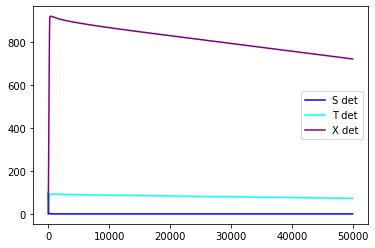

In [37]:
#Write the model M to a file
#Note that bioscrape saves the current state of the model and will not auto-save any changes to it
file_name = 'SignalTxTl.xml'
M.write_bioscrape_xml(file_name) 

M_loaded = Model(file_name)

#M_SBML = import_sbml('sbml_file.xml') #This code won't work without first creating an SBML File

#And the simulation will look the same as before
Results = py_simulate_model(timepoints, Model = M_loaded, stochastic = False)

plt.plot(timepoints, Results["S"]+Results["F1"], label = "S det", color = 'blue')
plt.plot(timepoints, Results["T"]+Results["T:R"], label = "T det", color = 'cyan')
plt.plot(timepoints, Results["X"], label = "X det", color = 'purple')
plt.legend()

> Important to save models with detail about the model, can be pain in the ass

## With any numerical software, errors are bound to occur. Below we explore the most common error: numerical errors, in the stochastic and deterministic regime.

1) Deterministic Blow-up usually results in an error from scipy.odeint: "...odeint failed with mxstep=500..." and sometimes a user warning about "excessive computation". This can occur due to numerical rounding errors, stiff ODEs, or numerical blow-up.
* To identify numerical blow-up, decrease the integration time and increase the number of time steps (decrease dt).
* To identify **stiff** equations, check to see if your rate constants span many orders of magnitude - if this is the case it may be possible to use a model reduction to improve integration (more details coming next lecture).
* Rounding errors might make ODEint complain, but typically can be ignored.

2) Stochastic blowup usually results in excessive time needed to run stochastic simulations or simulations that never finish. Sometimes, after breaking the stochastic simulator, the entire kernel needs to be restarted. These errors typically occur due species counts that are too large for the simulator to handle. If this is the case, a deterministic simulation might be more appropriate for your system. If species counts' don't appear to be the error, another common source is user defined propensities or rules resulting in improper values. These can be harder to catch and require care from the modeller
* To identify if the problem is due to large species counts, try running the simulation for much less time - if some species value is going very large, you can often catch it this way.
* **Safe Mode:** You can also try the keyword safe=True in py_simulate_model. This simulates the model in "safemode" which will try to catch blow up errors and other numerical errors in when simulating stochastic models. Safe-mode is not supported for deterministic simulations. Additionally, safemode has considerable overhead and can slow down simulation.

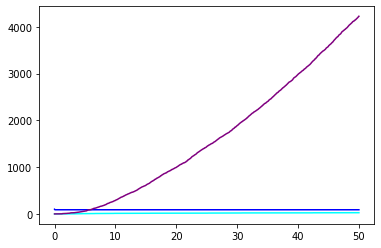

In [49]:
#Common Errors:

#Deterministic:
#Original values: 'delta':0.5,

#By making delta very small and the integration time very large, the simulator gets values that are too large.
#In the deterministic case, ODEint will raise a warning.

#In the stochastic case, the simulation might just not seem to work. 
#Sometimes, after breaking the stochastic simulator, you have to re-run the entire notebook.

#Do not change delta except in demo, as it can require kernel restarts
#M.set_parameter('delta', .00000001) 

timepoints = np.linspace(0, 50, 1000) #by shortenning the integration time, this error will go away.
Results = py_simulate_model(timepoints, Model = M, stochastic = False, safe = False)

plt.plot(timepoints, Results["S"]+Results["F1"], label = "S det", color = 'blue')
plt.plot(timepoints, Results["T"]+Results["T:R"], label = "T det", color = 'cyan')
plt.plot(timepoints, Results["X"], label = "X det", color = 'purple')

> For stochastic = True, make sure the number that you are going up to is small <br>
> safe = True is safe mode and will throw warnings if species count go above 1000. <br>
> safe = True has more overhead

## A Brief Preview of What's Coming Next
1. Next Week: Model Reductions (eg Hill Functions) via **Bioscrape**
2. Generating large models systematically via **BioCRNpyler**
3. Multi-compartment CRNs with **Subsbml**
4. Spatial Modelling of Bacteria with **Gro** (two weeks)
5. Connecting CRNs to Data: System Identification with **Bioscrape**
6. Modelling Well-Mixed Multi-cellular systems with **Bioscrape Lineages**
7. Advanced Topics including Automated Model Reduction and Circuit Design Tools

# Things to Try at Home:
Model a circuit/part/subsystem relevant to your research. To begin, write down a CRN that seems to describe all the chemical steps in your system (no simplifications such as hill functions - if you model all the chemical species' interactions step by step you should be able to model any system using mass-action kinetics. It is okay if this CRN is large and if you don't know all the parameter values - make a best guess or ask the TAs for help getting a ballpark estimate. Then, try varying some parameters (perhaps ones you could imagine manipulating experimentally). For example, you could titrate an inducer or set the value of a gene to 0 (knockout) or double it (over-expression). Does your circuit behave qualitatively differently when modelled stochastically?

If you don't have a circuit/system in mind, try modelling these two below:
* A bistable toggle switch: https://www.ncbi.nlm.nih.gov/pubmed/10659857
* The repressilator: https://www.nature.com/articles/35002125


## Delays:
* Delays: Reactions can also have delays (when simulated stochastically). This can be useful in modelling the time a complex molecular process takes. For example, transcription and protein foldering are not instaneous. Delays can cause very different dynamics for a circuit, including gain/loss of stability, oscillations, and chaos.
* For more information on delays, see the START_HERE notebook.


### References:
**Simulating Chemical Reaction Networks:**
* [Daniel T. Gillespie. Stochastic Simulation of Chemical Kinetics](http://cctbio.ece.umn.edu/wiki/images/7/78/Gillespie-Daniel-T_Stochastic_Simulation_of_Chemical_Kinetics.pdf). How stochastic CRN simulations work.
* [Swaminathan et al. Fast and flexible simulation and parameter estimation for synthetic biology using bioscrape](https://www.biorxiv.org/content/10.1101/121152v2). The paper introducing Bioscrape.

**Chemical Reaction Networks in Biology**:
* [Domitilla Del Vecchio and Richard M. Murray. Biomolecular Feedback Systems](http://www.cds.caltech.edu/~murray/BFSwiki/index.php/Main_Page). An excellent introduction to biochemical models, simulation, and theory.

**Mathematical Theory of Chemical Reaction Networks**:
* [Jeremy Gunawardena. Chemical reaction network theory for in-silico biologists](http://vcp.med.harvard.edu/papers/crnt.pdf). An introduction into some of the deeper theory of chemical reaction networks with many great references.
* [Soloveichik et al. Computation with finite stochastic chemical reaction networks](https://link.springer.com/article/10.1007/s11047-008-9067-y). Discusses the computational complexity of chemical reactions networks.

**Physics of Chemical Reaction Networks**:
* [Tim Schmiedl and Udo Seifert. Stochastic thermodynamics of chemical reaction networks.](https://aip.scitation.org/doi/full/10.1063/1.2428297). Detailed thermodynamic treatment of stochastic chemical reaction networks.
* [Riccardo Rao and Massimiliano Esposito. Nonequilibrium Thermodynamics of Chemical Reaction Networks:
Wisdom from Stochastic Thermodynamics.](https://arxiv.org/pdf/1602.07257.pdf). A detailed thermodynamic treatment of deterministic chemical reaction networks including many non-equilibrium examples.

> Try modeling stochastic vs deterministic in your own CRNs